In [1]:
import sys
sys.path.append('../../../../../src')
import os
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.datamodule import SHOWDataModule
from models.gcn_model import NodeEncodedGCN, NodeEncodedGCN_tt, NodeEncodedGCN_1l, NodeEncodedGCN_2l, NodeEncodedGCN_3l


def simple_model_evaluation(y_test, y_pred_test):
    # Simple model evaluation that computes and prints MSE, RMSE and MAPE for the training and testing set

    # train_error_mse = np.square(y_train - y_pred_train).sum() / y_train.shape[0]
    test_error_mse = np.square(y_test - y_pred_test).sum() / y_test.shape[0]

    # train_error_mape = (100 / y_train.shape[0]) * (
    #    np.absolute(y_train - y_pred_train) / y_train
    # ).sum()  # y_train should never be 0 since the travel time in a segment cannot be 0
    test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()

    test_error_mae = (1 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test)).sum()
    print("-----------MSE----------")
    # print("Training error: {}".format(train_error_mse))
    print("Testing error: {}".format(test_error_mse))
    print("-----------RMSE----------")
    # print("Training error: {}".format(np.sqrt(train_error_mse)))
    print("Testing error: {}".format(np.sqrt(test_error_mse)))
    print("-----------MAPE----------")
    # print("Training error: {:.2f} %".format(train_error_mape))
    print("Testing error: {:.2f} %".format(test_error_mape))
    print("-----------MAE----------")
    print("Testing error: {}".format(test_error_mae))
    return test_error_mse, np.sqrt(test_error_mse), test_error_mape, test_error_mae



/home/manity/SHOW_folder/SHOW_ML_Service/envs/show_env1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Path for the checkpoint directory

# Load the datamodule
site_name = 'TAMPERE_FINAL'
transform_type = 'maxmin'
batch_size = 64
empty_graph = False
time_kind = 'dwell_times'
data_module = SHOWDataModule(
    site_name=site_name,
    transform=transform_type,
    num_lags=2,
    train_frac=0.9,
    batch_size=batch_size,
    empty_graph=empty_graph,
    verbose=False,
    time_kind=time_kind,
)
transform = data_module.setup()

data_module_rf = SHOWDataModule(
    site_name=site_name,
    transform=transform_type,
    num_lags=2,
    train_frac=0.9,
    batch_size=batch_size,
    empty_graph=empty_graph,
    verbose=False,
    time_kind=time_kind,
    rf_remove_zero_obs=True,
    
)
transform_rf = data_module_rf.setup()

** Removing zero obs based on RF classifier ***
Confusion matrix train: [2585    0    0 3343]
Confusion matrix test: [265 111  72 320]


In [3]:
model_names = os.listdir('.')
# remove any files that don't end with .ckpt
model_names = [name for name in model_names if name.endswith('.ckpt')]

In [4]:
model_names

['ne_gcn-5124-07271142.ckpt',
 'ne_gcn-4239-07271142.ckpt',
 'ne_gcn-6105-07271142.ckpt',
 'ne_gcn-9788-07271142.ckpt']

In [5]:
results = []
# Load model checkpoint
for model_name in model_names:
    print(model_name)
    checkpoint_dict = torch.load(model_name)
    model = NodeEncodedGCN_1l(
        transform=checkpoint_dict['hyper_parameters']['transform'],
        weight_decay=checkpoint_dict['hyper_parameters']['weight_decay'],
        lr=checkpoint_dict['hyper_parameters']['lr'],
        drop_p=checkpoint_dict['hyper_parameters']['drop_p'],
        batch_size=checkpoint_dict['hyper_parameters']['batch_size'],
        input_size=checkpoint_dict['hyper_parameters']['input_size'],
        hidden_layers=checkpoint_dict['hyper_parameters']['hidden_layers'],
        aggregation_function=checkpoint_dict['hyper_parameters']['aggregation_function'],
    )
    model = model.load_from_checkpoint(model_name)

    trainer = pl.Trainer(gpus=1)

    output = trainer.predict(model, dataloaders=data_module.test_dataloader())
    y_hat = np.concatenate([out[0] for out in output])
    y_true = np.concatenate([out[1] for out in output])

    #df = pd.DataFrame({'y_true': y_true, 'y_hat': y_hat})
    #df.to_csv(f'{model_name}_pred.csv', index=False)

    print('****BEFORE RF ZERO FIXING****')
    simple_model_evaluation(y_true, y_hat)
    print('*****************************')

    y_hat_rf = np.zeros_like(y_hat)
    y_hat_rf[data_module_rf.non_zero_indices_test] = y_hat[data_module_rf.non_zero_indices_test]
    print(' *** AFTER RF ZERO FIXING ****')
    temp_res = simple_model_evaluation(y_hat_rf, y_true)
    results.append(temp_res)
    print('*****************************')

ne_gcn-5124-07271142.ckpt


/home/manity/SHOW_folder/SHOW_ML_Service/envs/show_env1/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/manity/SHOW_folder/SHOW_ML_Service/envs/show_env1/lib/python3.9/site-packages/pytorch_lig

Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 14.64it/s]

/tmp/ipykernel_659032/205311161.py:24: RuntimeWarning: divide by zero encountered in divide
  test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()
/tmp/ipykernel_659032/205311161.py:24: RuntimeWarning: invalid value encountered in divide
  test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



****BEFORE RF ZERO FIXING****
-----------MSE----------
Testing error: 201.42118326822916
-----------RMSE----------
Testing error: 14.192293094078531
-----------MAPE----------
Testing error: inf %
-----------MAE----------
Testing error: 11.50912348429362
*****************************
 *** AFTER RF ZERO FIXING ****
-----------MSE----------
Testing error: 161.6777140299479
-----------RMSE----------
Testing error: 12.715255169675043
-----------MAPE----------
Testing error: nan %
-----------MAE----------
Testing error: 7.6587982177734375
*****************************
ne_gcn-4239-07271142.ckpt
Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 55.84it/s] 
****BEFORE RF ZERO FIXING****
-----------MSE----------
Testing error: 197.165771484375
-----------RMSE----------
Testing error: 14.041572970446545
-----------MAPE----------
Testing error: inf %
-----------MAE----------
Testing error: 11.349886576334635
*****************************
 *** AFTER RF ZERO FIXING ****
-----------MSE--

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 62.39it/s] 
****BEFORE RF ZERO FIXING****
-----------MSE----------
Testing error: 197.40608723958334
-----------RMSE----------
Testing error: 14.05012765919169
-----------MAPE----------
Testing error: inf %
-----------MAE----------
Testing error: 11.352307637532551
*****************************
 *** AFTER RF ZERO FIXING ****
-----------MSE----------
Testing error: 161.21728515625
-----------RMSE----------
Testing error: 12.697136888143326
-----------MAPE----------
Testing error: nan %
-----------MAE----------
Testing error: 7.6663576761881504
*****************************
ne_gcn-9788-07271142.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 55.71it/s] 
****BEFORE RF ZERO FIXING****
-----------MSE----------
Testing error: 194.2611287434896
-----------RMSE----------
Testing error: 13.937759100497095
-----------MAPE----------
Testing error: inf %
-----------MAE----------
Testing error: 11.148255666097004
*****************************
 *** AFTER RF ZERO FIXING ****
-----------MSE----------
Testing error: 164.15243530273438
-----------RMSE----------
Testing error: 12.812198691197947
-----------MAPE----------
Testing error: nan %
-----------MAE----------
Testing error: 7.659528096516927
*****************************


In [6]:
results
mse_arr = np.array([res[0] for res in results])
rmse_arr = np.array([res[1] for res in results])
mape_arr = np.array([res[2] for res in results])
mae_arr = np.array([res[3] for res in results])

In [7]:

print(f'Results for {site_name} with {type(transform)} transform and {time_kind} time kind')
print(f'MSE: {mse_arr.mean()} +/- {mse_arr.std()}')
print(f'MAE: {mae_arr.mean()} +/- {mae_arr.std()}')
print(f'RMSE: {rmse_arr.mean()} +/- {rmse_arr.std()}')

Results for TAMPERE_FINAL with <class 'data.datamodule.MaxMin'> transform and dwell_times time kind
MSE: 162.02840932210285 +/- 1.2468196901464355
MAE: 7.654875596364339 +/- 0.011949499998825832
RMSE: 12.728944194275519 +/- 0.04887761371456187


In [8]:
best_model_idx = np.argmin(mse_arr)

In [9]:
model_name = model_names[best_model_idx]
checkpoint_dict = torch.load(model_name)
model = NodeEncodedGCN_1l(
    transform=checkpoint_dict['hyper_parameters']['transform'],
    weight_decay=checkpoint_dict['hyper_parameters']['weight_decay'],
    lr=checkpoint_dict['hyper_parameters']['lr'],
    drop_p=checkpoint_dict['hyper_parameters']['drop_p'],
    batch_size=checkpoint_dict['hyper_parameters']['batch_size'],
    input_size=checkpoint_dict['hyper_parameters']['input_size'],
    hidden_layers=checkpoint_dict['hyper_parameters']['hidden_layers'],
    aggregation_function=checkpoint_dict['hyper_parameters']['aggregation_function'],
)
model = model.load_from_checkpoint(model_name)

trainer = pl.Trainer(gpus=1)

output = trainer.predict(model, dataloaders=data_module.test_dataloader())
y_hat = np.concatenate([out[0] for out in output])
y_true = np.concatenate([out[1] for out in output])


print('****BEFORE RF ZERO FIXING****')
simple_model_evaluation(y_true, y_hat)
print('*****************************')

y_hat_rf = np.zeros_like(y_hat)
y_hat_rf[data_module_rf.non_zero_indices_test] = y_hat[data_module_rf.non_zero_indices_test]
print(' *** AFTER RF ZERO FIXING ****')
temp_res = simple_model_evaluation(y_hat_rf, y_true)
results.append(temp_res)
print('*****************************')

df = pd.DataFrame({'y_true': y_true, 'y_hat': y_hat_rf, 'date': data_module.test_dates})
df.to_csv(f'{model_name}_pred.csv', index=False)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 55.53it/s] 
****BEFORE RF ZERO FIXING****
-----------MSE----------
Testing error: 197.165771484375
-----------RMSE----------
Testing error: 14.041572970446545
-----------MAPE----------
Testing error: inf %
-----------MAE----------
Testing error: 11.349886576334635
*****************************
 *** AFTER RF ZERO FIXING ****
-----------MSE----------
Testing error: 161.06620279947916
-----------RMSE----------
Testing error: 12.691186028085758
-----------MAPE----------
Testing error: nan %
-----------MAE----------
Testing error: 7.634818394978841
*****************************


/tmp/ipykernel_659032/205311161.py:24: RuntimeWarning: divide by zero encountered in divide
  test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()
/tmp/ipykernel_659032/205311161.py:24: RuntimeWarning: invalid value encountered in divide
  test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()


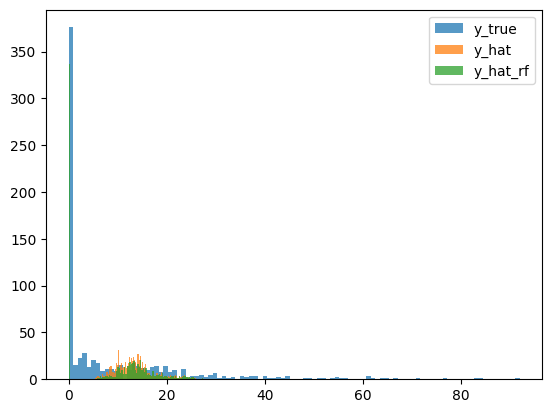

In [10]:
fig, ax = plt.subplots()
ax.hist(y_true, bins=100, alpha=0.75)
ax.hist(y_hat, bins=100, alpha=0.75)
ax.hist(y_hat_rf, bins=100, alpha=0.75)
ax.legend(['y_true', 'y_hat', 'y_hat_rf'])

In [11]:
output = trainer.predict(model, dataloaders=data_module_rf.test_dataloader())
y_hat = np.concatenate([out[0] for out in output])
y_true = np.concatenate([out[1] for out in output])

#df = pd.DataFrame({'y_true': y_true, 'y_hat': y_hat})
#df.to_csv(f'{model_name}_pred.csv', index=False)

print('****Safety check****')
print(f'{model_names[best_model_idx]}')
simple_model_evaluation(y_true, y_hat)
print('*****************************')

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/manity/SHOW_folder/SHOW_ML_Service/envs/show_env1/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 41.76it/s] 
****Safety check****
ne_gcn-4239-07271142.ckpt
-----------MSE----------
Testing error: 224.50775812064964
-----------RMSE----------
Testing error: 14.983582953374324
-----------MAPE----------
Testing error: inf %
-----------MAE----------
Testing error: 11.094060415458236
*****************************


/tmp/ipykernel_659032/205311161.py:24: RuntimeWarning: divide by zero encountered in divide
  test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()


In [12]:
y_hat_rf

array([11.496338 ,  9.775331 ,  6.7919927,  0.       ,  0.       ,
        8.985818 ,  0.       , 12.014425 ,  9.789407 ,  0.       ,
        0.       ,  0.       ,  9.181258 ,  0.       , 12.08317  ,
       11.07411  ,  7.8603716,  0.       , 12.8585   , 10.1027155,
        0.       , 12.479847 ,  0.       ,  0.       , 16.273756 ,
        0.       ,  0.       ,  0.       , 14.144027 , 12.5398245,
        7.820635 , 13.721009 ,  0.       ,  0.       ,  0.       ,
        0.       , 10.60962  ,  8.107154 , 13.832729 ,  0.       ,
        0.       ,  0.       ,  0.       , 10.074494 ,  0.       ,
       13.289522 ,  0.       ,  0.       , 18.39261  , 14.327365 ,
       10.124605 ,  8.467695 , 13.070946 , 12.289224 ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  9.91142  ,
       15.011268 ,  0.       ,  9.646951 , 19.883518 ,  0.       ,
       10.729084 ,  0.       , 14.118629 ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       , 13.3688